In [1]:
%matplotlib inline

In [2]:
import datetime
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from __future__ import division

In [3]:
data = pd.read_csv('trip_data_1.csv', skipinitialspace=True, nrows = 110000)

In [4]:
data_fare = pd.read_csv('trip_fare_1.csv',skipinitialspace = True, nrows = 110000 )

In [5]:
data_fare.head()


,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,2013-01-01 15:11:48,CSH,6.5,0.0,0.5,0,0,7.0
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,2013-01-06 00:18:35,CSH,6.0,0.5,0.5,0,0,7.0
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,2013-01-05 18:49:41,CSH,5.5,1.0,0.5,0,0,7.0
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,2013-01-07 23:54:15,CSH,5.0,0.5,0.5,0,0,6.0
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,2013-01-07 23:25:03,CSH,9.5,0.5,0.5,0,0,10.5


In [6]:
data_fare['tip_percent'] = data_fare['tip_amount'] / (data_fare['fare_amount'] + data_fare['surcharge'] + data_fare['mta_tax'])

In [7]:
(data_fare['tip_percent']).quantile(0.99)

0.29399999999999998

In [8]:
data_fare = data_fare.drop(data_fare[data_fare.tip_percent > 1].index)

In [9]:
data_fare.shape

(109942, 12)

In [10]:
data = data[:100000]

In [11]:
data_fare = data_fare[:100000]

In [12]:
result = pd.concat([data, data_fare], axis=1)

In [13]:
result.shape

(100051, 26)

In [14]:
# temp[0] = "medallion_1"
# temp[1] = "hack_license_1"


In [15]:
# result.columns = temp

In [135]:
# df = result[result['medallion_1'] == result['medallion']]

In [137]:
# df.shape

(99949, 26)

In [153]:
temp_df = result

In [16]:
annual_holidays = pd.read_csv('nyc_2013_holidays.csv')

In [18]:
annual_holidays

,Month,Day
0,1,1
1,1,21


In [19]:
datetime_necesary_columns = ['pickup_datetime']
datetime_column_names = ['pickup_month', 'pickup_weekday', 'pickup_day', 'pickup_time_in_mins', 'pickup_non_working_today',
                         'pickup_non_working_tomorrow']

# It says if a day is a holiday in NYC.
def is_in_annual_holidays(the_day):
    return annual_holidays[(annual_holidays.Month == the_day.month) & (annual_holidays.Day == the_day.day)].shape[0]

# It calculates data related with 'pickup_datetime'.
def calculate_datetime_extra(row):
    dt = datetime.datetime.strptime(row.pickup_datetime, '%Y-%m-%d %H:%M:%S')
    pickup_month = dt.month
    pickup_weekday = dt.weekday()
    pickup_day = dt.day
    pickup_time_in_mins = (dt.hour * 60) + dt.minute
    pickup_non_working_today = int((pickup_weekday == 5) or (pickup_weekday == 6) or is_in_annual_holidays(dt))
    pickup_non_working_tomorrow = int((pickup_weekday == 4) or (pickup_weekday == 5) or
                                      is_in_annual_holidays(dt + datetime.timedelta(days=1)))
    
    return pd.Series({
        datetime_column_names[0]: pickup_month,
        datetime_column_names[1]: pickup_weekday,
        datetime_column_names[2]: pickup_day,
        datetime_column_names[3]: pickup_time_in_mins,
        datetime_column_names[4]: pickup_non_working_today,
        datetime_column_names[5]: pickup_non_working_tomorrow
    })

In [20]:
def iterate_and_apply(dataframe, function, necesary_columns):
    perform = True
    step = len(dataframe.index)
    start = 0
    to = step
    
    while perform:
        new_columns = dataframe[start:to][necesary_columns].apply(function, axis=1)
        if len(new_columns) == 0:
            perform = False
        else:
            dataframe.update(new_columns)
        new_columns = None
        start += step
        to += step
    
    return dataframe


In [21]:
# df.dtypes

In [22]:
for column in datetime_column_names:
    data[column] = np.nan

f_df = iterate_and_apply(data, calculate_datetime_extra, datetime_necesary_columns)

In [23]:
f_df.shape

(100000, 20)

In [26]:
for i , x in enumerate(f_df.columns):
    print i,x

0 medallion
1 hack_license
2 vendor_id
3 rate_code
4 store_and_fwd_flag
5 pickup_datetime
6 dropoff_datetime
7 passenger_count
8 trip_time_in_secs
9 trip_distance
10 pickup_longitude
11 pickup_latitude
12 dropoff_longitude
13 dropoff_latitude
14 pickup_month
15 pickup_weekday
16 pickup_day
17 pickup_time_in_mins
18 pickup_non_working_today
19 pickup_non_working_tomorrow


In [27]:
des = f_df.ix[:,14:20].copy() 

In [28]:
des

,pickup_month,pickup_weekday,pickup_day,pickup_time_in_mins,pickup_non_working_today,pickup_non_working_tomorrow
0,1,1,1,911,1,0
1,1,6,6,18,1,0
2,1,5,5,1129,1,1
3,1,0,7,1434,0,0
4,1,0,7,1405,0,0
5,1,0,7,927,0,0
6,1,1,8,661,0,0
7,1,0,7,759,0,0
8,1,0,7,1095,0,0
9,1,0,7,933,0,0


In [24]:
for i , x in enumerate(result.columns):
    print i,x

0 medallion
1 hack_license
2 vendor_id
3 rate_code
4 store_and_fwd_flag
5 pickup_datetime
6 dropoff_datetime
7 passenger_count
8 trip_time_in_secs
9 trip_distance
10 pickup_longitude
11 pickup_latitude
12 dropoff_longitude
13 dropoff_latitude
14 medallion
15 hack_license
16 vendor_id
17 pickup_datetime
18 payment_type
19 fare_amount
20 surcharge
21 mta_tax
22 tip_amount
23 tolls_amount
24 total_amount
25 tip_percent


In [29]:
des.loc[:1,'pickup_non_working_tomorrow']

0    0
1    0
Name: pickup_non_working_tomorrow, dtype: float64

In [30]:
final = pd.concat([result, des], axis=1)

In [31]:
final.head()

,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,tip_amount,tolls_amount,total_amount,tip_percent,pickup_month,pickup_weekday,pickup_day,pickup_time_in_mins,pickup_non_working_today,pickup_non_working_tomorrow
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,...,0,0,7.0,0,1,1,1,911,1,0
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,...,0,0,7.0,0,1,6,6,18,1,0
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,...,0,0,7.0,0,1,5,5,1129,1,1
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,...,0,0,6.0,0,1,0,7,1434,0,0
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,...,0,0,10.5,0,1,0,7,1405,0,0


In [254]:
# p_result = result.drop(result.columns[[20,21,22]], axis=1, inplace=False)

In [32]:
# for i , x in enumerate(p_result.columns):
#     print i,x

In [34]:
# result

In [35]:
set(result.columns) - set(f_df.columns)

{'fare_amount',
 'mta_tax',
 'payment_type',
 'surcharge',
 'tip_amount',
 'tip_percent',
 'tolls_amount',
 'total_amount'}

In [218]:
#processed  = pd.concat([result, f_df], axis=1)

In [36]:
processed = final

In [37]:
tip_label_column_name = 'tip_label'

tip_labels = ['[0-10)', '[10-15)', '[15-20)', '[20-25)', '[25-30)', '[30-inf)']
tip_ranges_by_label = [[0, 0.10], [0.10, 0.15], [0.15, 0.20], [0.20, 0.25], [0.25, 0.30], [0.30, 1.00]]

In [39]:
processed.loc[5, ['pickup_month']]

pickup_month    1
Name: 5, dtype: object

In [45]:
columns = list(processed.columns )

In [46]:
columns[0] = 'medallion1'
columns[1] = 'hack_license1'
columns[2] = 'vendor_id1'

In [47]:
processed.columns = columns

In [51]:
for i , x in enumerate(processed.columns):
    print i,x

0 medallion1
1 hack_license1
2 vendor_id1
3 rate_code
4 store_and_fwd_flag
5 pickup_datetime
6 dropoff_datetime
7 passenger_count
8 trip_time_in_secs
9 trip_distance
10 pickup_longitude
11 pickup_latitude
12 dropoff_longitude
13 dropoff_latitude
14 pickup_datetime
15 payment_type
16 fare_amount
17 surcharge
18 mta_tax
19 tip_amount
20 tolls_amount
21 total_amount
22 tip_percent
23 pickup_month
24 pickup_weekday
25 pickup_day
26 pickup_time_in_mins
27 pickup_non_working_today
28 pickup_non_working_tomorrow


In [50]:
processed = processed.drop(result.columns[[14,15,16]], axis=1, inplace=False)

In [66]:
processed = processed[processed.tip_percent.notnull()]
processed = processed[processed.medallion1.notnull()]

In [67]:
processed.shape

(99949, 30)

In [68]:
processed['tip_label'] = ''
def label_race (row):
    if row['tip_percent'] < 0.1 :
      return '[0-10)'
    if row['tip_percent'] < 0.15 :
      return '[10-15)'
    if row['tip_percent'] < 0.2 :
      return '[15-20)'
    if row['tip_percent'] < 0.25 :
      return '[20-25)'
    if row['tip_percent'] < 0.3 :
      return '[25-30)'
    else:
      return '[30-100)'
 

In [69]:
processed['tip_label'] = processed.apply (lambda row: label_race (row),axis=1)

In [70]:
processed['tip_label']

0         [0-10)
1         [0-10)
2         [0-10)
3         [0-10)
4         [0-10)
5         [0-10)
6         [0-10)
7         [0-10)
8         [0-10)
9         [0-10)
10        [0-10)
11        [0-10)
12        [0-10)
13        [0-10)
14        [0-10)
15        [0-10)
16        [0-10)
17        [0-10)
18        [0-10)
19        [0-10)
20        [0-10)
21        [0-10)
22        [0-10)
23        [0-10)
24        [0-10)
25        [0-10)
26        [0-10)
27        [0-10)
28        [0-10)
29        [0-10)
          ...   
99970     [0-10)
99971     [0-10)
99972    [20-25)
99973     [0-10)
99974     [0-10)
99975     [0-10)
99976     [0-10)
99977     [0-10)
99978     [0-10)
99979     [0-10)
99980    [15-20)
99981     [0-10)
99982    [15-20)
99983    [20-25)
99984     [0-10)
99985    [15-20)
99986    [15-20)
99987    [15-20)
99988     [0-10)
99989    [15-20)
99990    [15-20)
99991     [0-10)
99992     [0-10)
99993     [0-10)
99994     [0-10)
99995    [15-20)
99996     [0-10)
99997    [15-2

In [71]:
processed.head()

,medallion1,hack_license1,vendor_id1,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,tolls_amount,total_amount,tip_percent,pickup_month,pickup_weekday,pickup_day,pickup_time_in_mins,pickup_non_working_today,pickup_non_working_tomorrow,tip_label
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.0,...,0,7.0,0,1,1,1,911,1,0,[0-10)
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.5,...,0,7.0,0,1,6,6,18,1,0,[0-10)
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.1,...,0,7.0,0,1,5,5,1129,1,1,[0-10)
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.7,...,0,6.0,0,1,0,7,1434,0,0,[0-10)
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.1,...,0,10.5,0,1,0,7,1405,0,0,[0-10)


In [73]:
processed

,medallion1,hack_license1,vendor_id1,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,...,tolls_amount,total_amount,tip_percent,pickup_month,pickup_weekday,pickup_day,pickup_time_in_mins,pickup_non_working_today,pickup_non_working_tomorrow,tip_label
0,89D227B655E5C82AECF13C3F540D4CF4,BA96DE419E711691B9445D6A6307C170,CMT,1,N,2013-01-01 15:11:48,2013-01-01 15:18:10,4,382,1.00,...,0.0,7.00,0.000000,1,1,1,911,1,0,[0-10)
1,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-06 00:18:35,2013-01-06 00:22:54,1,259,1.50,...,0.0,7.00,0.000000,1,6,6,18,1,0,[0-10)
2,0BD7C8F5BA12B88E0B67BED28BEA73D8,9FD8F69F0804BDB5549F40E9DA1BE472,CMT,1,N,2013-01-05 18:49:41,2013-01-05 18:54:23,1,282,1.10,...,0.0,7.00,0.000000,1,5,5,1129,1,1,[0-10)
3,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:54:15,2013-01-07 23:58:20,2,244,0.70,...,0.0,6.00,0.000000,1,0,7,1434,0,0,[0-10)
4,DFD2202EE08F7A8DC9A57B02ACB81FE2,51EE87E3205C985EF8431D850C786310,CMT,1,N,2013-01-07 23:25:03,2013-01-07 23:34:24,1,560,2.10,...,0.0,10.50,0.000000,1,0,7,1405,0,0,[0-10)
5,20D9ECB2CA0767CF7A01564DF2844A3E,598CCE5B9C1918568DEE71F43CF26CD2,CMT,1,N,2013-01-07 15:27:48,2013-01-07 15:38:37,1,648,1.70,...,0.0,10.00,0.000000,1,0,7,927,0,0,[0-10)
6,496644932DF3932605C22C7926FF0FE0,513189AD756FF14FE670D10B92FAF04C,CMT,1,N,2013-01-08 11:01:15,2013-01-08 11:08:14,1,418,0.80,...,0.0,6.50,0.000000,1,1,8,661,0,0,[0-10)
7,0B57B9633A2FECD3D3B1944AFC7471CF,CCD4367B417ED6634D986F573A552A62,CMT,1,N,2013-01-07 12:39:18,2013-01-07 13:10:56,3,1898,10.70,...,4.8,39.30,0.000000,1,0,7,759,0,0,[0-10)
8,2C0E91FF20A856C891483ED63589F982,1DA2F6543A62B8ED934771661A9D2FA0,CMT,1,N,2013-01-07 18:15:47,2013-01-07 18:20:47,1,299,0.80,...,0.0,7.00,0.000000,1,0,7,1095,0,0,[0-10)
9,2D4B95E2FA7B2E85118EC5CA4570FA58,CD2F522EEE1FF5F5A8D8B679E23576B3,CMT,1,N,2013-01-07 15:33:28,2013-01-07 15:49:26,2,957,2.50,...,0.0,13.50,0.000000,1,0,7,933,0,0,[0-10)


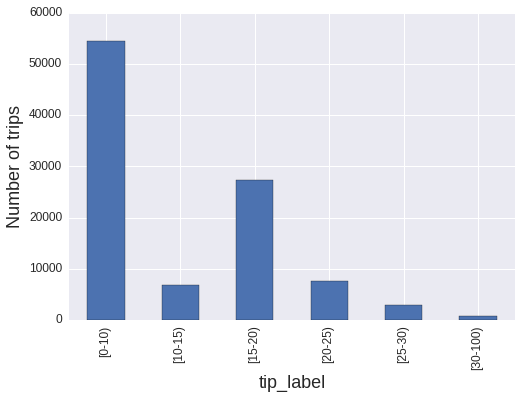

In [74]:
ax = processed.groupby('tip_label').size().plot(kind='bar')

ax.set_xlabel('tip_label', fontsize=18)
ax.set_ylabel('Number of trips', fontsize=18)
ax.tick_params(labelsize=12)

In [75]:
processed.shape

(99949, 30)

In [76]:
(processed['tip_percent']).quantile(0.99)


0.29268292682926828

In [77]:
from matplotlib import cm as cmap

from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [78]:
columns = list(processed.columns )
columns[0] = 'medallion'
columns[1] = 'hack_license'
columns[2] = 'vendor_id'
processed.columns = columns

In [128]:
labelize_columns = ['medallion', 'hack_license', 'vendor_id']

interize_columns = ['pickup_month', 'pickup_weekday', 'pickup_non_working_today', 'pickup_non_working_tomorrow']

feature_columns = [ 'pickup_month', 'pickup_weekday', 'pickup_day',
                   'pickup_time_in_mins', 'pickup_non_working_today', 'pickup_non_working_tomorrow', 'fare_amount',
                   'passenger_count', 'trip_time_in_secs', 'trip_distance'] # 'pickup_longitude',
                #   'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

class_column = 'tip_label'

In [129]:
for column in labelize_columns:
    real_column = processed[column].values
    
    le = LabelEncoder()
    le.fit(real_column)
    labelized_column = le.transform(real_column)
    
    processed[column] = labelized_column
    
    le = None
    real_column = None
    labelized_column = None

In [130]:
for column in interize_columns:
    processed[column] = processed[column].astype(int)

In [131]:
data_features = processed[feature_columns].values
data_classes = processed[class_column].values

In [132]:
cross_validation = StratifiedShuffleSplit(data_classes, n_iter=10, test_size=0.1, random_state=0)

scores = []
confusion_matrices = []


In [133]:
for train_index, test_index in cross_validation:
    data_features_train, data_classes_train = data_features[train_index], data_classes[train_index]
    data_features_test, data_classes_test = data_features[test_index], data_classes[test_index]
    clf = RandomForestClassifier(n_estimators=256, n_jobs=-1)
    clf.fit(data_features_train, data_classes_train)
    # Saving the scores.
    test_score = clf.score(data_features_test, data_classes_test)
    scores.append(test_score)
    
    # Saving the confusion matrices.
    data_classes_pred = clf.predict(data_features_test)
    cm = confusion_matrix(data_classes_test, data_classes_pred)
    confusion_matrices.append(cm)
    
    clf = None
    
    
    

In [134]:
print 'Accuracy mean: ' + str(np.mean(scores))
print 'Accuracy std: ' + str(np.std(scores))

Accuracy mean: 0.473476738369
Accuracy std: 0.00371486160532


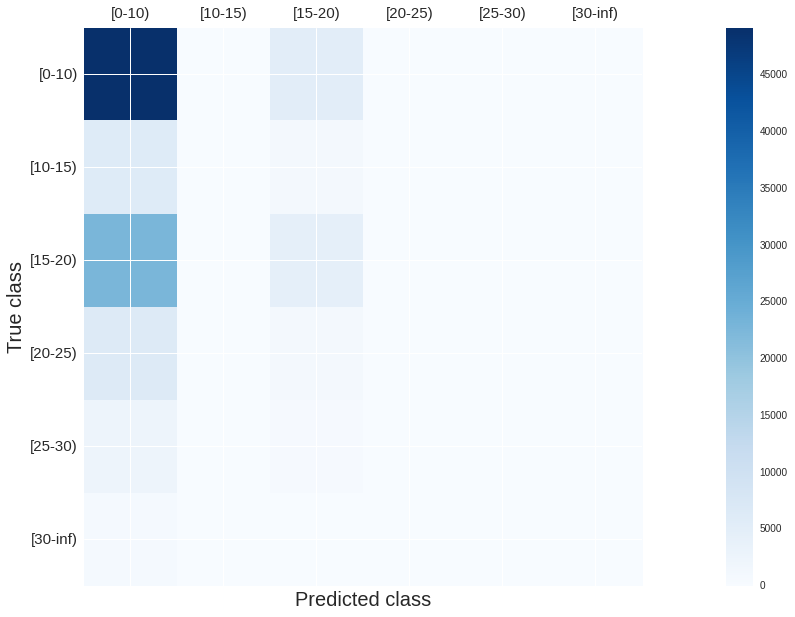

In [114]:
classes = [' ', '[0-10)', '[10-15)', '[15-20)', '[20-25)', '[25-30)', '[30-inf)']

first = True
cm = None

for cm_iter in confusion_matrices:
    if first:
        cm = cm_iter.copy()
        first = False
    else:
        cm = cm + cm_iter

fig, axes = plt.subplots(figsize=(30, 10))

colorbar = axes.matshow(cm, cmap=cmap.Blues) 
fig.colorbar(colorbar, ticks=[0, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 60000, 70000, 80000, 90000, 100000])

axes.set_xlabel('Predicted class', fontsize=20)
axes.set_ylabel('True class', fontsize=20)

axes.set_xticklabels(classes)
axes.set_yticklabels(classes)

axes.tick_params(labelsize=15)
fig.savefig('confusion_matrix1.svg', format='svg', dpi=1200)